In [ ]:
pip install yfinance

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import math
from sklearn.metrics import mean_squared_error
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
plt.style.use("fivethirtyeight")

[*********************100%***********************]  1 of 1 completed
Epoch 1/25
61/61 [==============================] - 28s 63ms/step - loss: 0.0362
Epoch 2/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0026
Epoch 3/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0024
Epoch 4/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0017
Epoch 5/25
61/61 [==============================] - 4s 64ms/step - loss: 0.0017
Epoch 6/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0019
Epoch 7/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0015
Epoch 8/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0015
Epoch 9/25
61/61 [==============================] - 4s 64ms/step - loss: 0.0015
Epoch 10/25
61/61 [==============================] - 4s 63ms/step - loss: 0.0013
Epoch 11/25
61/61 [==============================] - 4s 64ms/step - loss: 0.0014
Epoch 12/25
61/61 [=============================

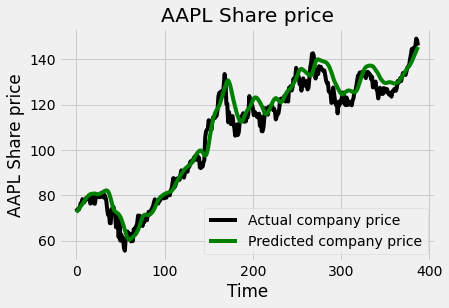

Prediction: [[146.18962]]


In [ ]:
#MODELO: RNN (LSTM)

ticker ="AAPL"

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = yf.download(ticker, start, end)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data["Adj Close"].values.reshape(-1,1))

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50)) 
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=25, batch_size=32)

#BACKTESTING

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = yf.download(ticker, test_start, test_end)

actual_prices = test_data["Adj Close"].values

total_dataset = pd.concat((data["Adj Close"], test_data["Adj Close"]), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

plt.plot(actual_prices, color="black", label=f"Actual company price")
plt.plot(predicted_prices, color="green", label=f"Predicted company price")
plt.title(f"{ticker} Share price")
plt.xlabel("Time")
plt.ylabel(f"{ticker} Share price")
plt.legend()
plt.show()

real_data = [model_inputs[len(model_inputs) + 1  - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

[*********************100%***********************]  1 of 1 completed
Epoch 1/100
12/12 [==============================] - 8s 258ms/step - loss: 0.0168 - val_loss: 0.0525
Epoch 2/100
12/12 [==============================] - 2s 182ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 3/100
12/12 [==============================] - 2s 177ms/step - loss: 7.8946e-04 - val_loss: 0.0047
Epoch 4/100
12/12 [==============================] - 2s 167ms/step - loss: 6.2512e-04 - val_loss: 0.0037
Epoch 5/100
12/12 [==============================] - 2s 165ms/step - loss: 5.4732e-04 - val_loss: 0.0047
Epoch 6/100
12/12 [==============================] - 2s 166ms/step - loss: 5.1595e-04 - val_loss: 0.0036
Epoch 7/100
12/12 [==============================] - 2s 166ms/step - loss: 5.0590e-04 - val_loss: 0.0034
Epoch 8/100
12/12 [==============================] - 2s 167ms/step - loss: 5.0203e-04 - val_loss: 0.0032
Epoch 9/100
12/12 [==============================] - 2s 167ms/step - loss: 5.1514e-04 - val_loss: 0

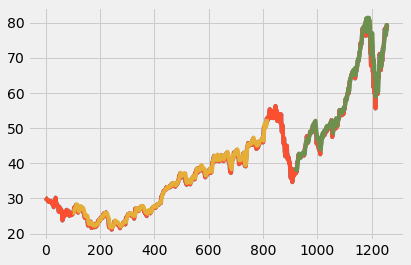

In [55]:
ticker = "AAPL"

start = dt.datetime(2015,5,27)
end = dt.datetime(2020,5,23)

df = yf.download(ticker, start, end)
df1 = df.reset_index()['Adj Close']
plt.plot(df1)

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)
 
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [56]:
x_input=test_data[341:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0

while (i<30):
  if (len(temp_input)>100):
    #print(temp_input)
    x_input=np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input))
    x_input=x_input.reshape(1,-1)
    x_input = x_input.reshape((1, n_steps, 1))
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    print("{} day output {}".format(i,yhat))
    temp_input.extend(yhat[0].tolist())
    temp_input=temp_input[1:]
    #print(temp_input)
    lst_output.extend(yhat.tolist())
    i=i+1
  else:
    x_input = x_input.reshape((1, n_steps,1))
    yhat = model.predict(x_input, verbose=0)
    print(yhat[0])
    temp_input.extend(yhat[0].tolist())
    print(len(temp_input))
    lst_output.extend(yhat.tolist())
    i=i+1


day_new=np.arange(1,101)
day_pred=np.arange(101,131)

[0.978903]
101
1 day input [0.88611421 0.87407704 0.88384696 0.87803453 0.89782169 0.92436939
 0.92725505 0.95458599 0.93694248 0.93141875 0.94749564 0.96188269
 0.95297851 0.95763675 0.96394385 0.96015134 0.92156635 0.95759551
 0.98500881 0.98307138 0.92387485 0.92037092 0.96237736 0.97309537
 0.98859536 0.97037278 0.97665353 0.9686371  1.         0.99037202
 0.99070273 0.96611666 0.98520688 0.97148839 0.94153033 0.88008589
 0.83835173 0.85723549 0.77818827 0.7775271  0.88268933 0.8434755
 0.8989284  0.8583511  0.84227739 0.74781726 0.82702983 0.78608058
 0.67368721 0.79657608 0.64881185 0.69281887 0.6672411  0.65943134
 0.59521848 0.57509506 0.66810893 0.66248916 0.71587606 0.67166245
 0.70087641 0.69872772 0.64344018 0.6600512  0.64550625 0.73252833
 0.71996682 0.74740406 0.75533749 0.77707253 0.83409549 0.82326953
 0.83260817 0.81653421 0.79227872 0.75690793 0.78884913 0.78442765
 0.81723662 0.81806315 0.79909691 0.83690553 0.86198742 0.84244275
 0.85934286 0.8775242  0.89020969 0.

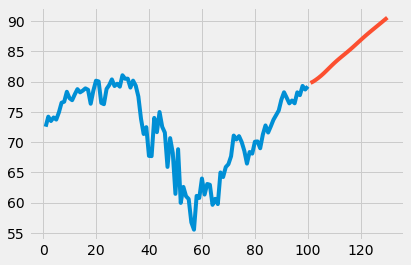

In [57]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

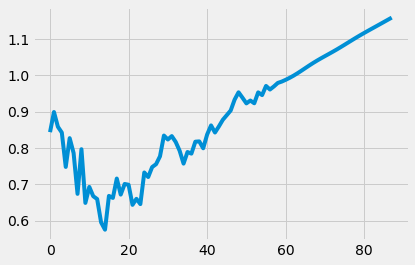

In [58]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

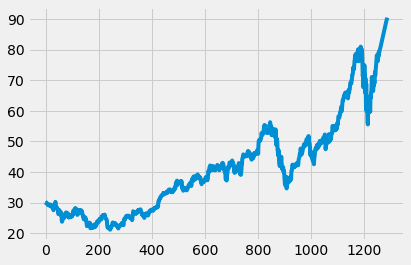

In [59]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)